In [1]:
import transformers
import datasets

print(f"Running on transformers v{transformers.__version__} and datasets v{datasets.__version__}")

Running on transformers v4.7.0 and datasets v1.8.0


In [2]:
import torch
from pathlib import Path
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          TrainingArguments, Trainer)

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import unicodedata
import re

import seaborn as sns
import matplotlib.pyplot as plt
import random
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
import os

In [3]:
def set_seed(seed = 0):
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

seed=1112
random_state = set_seed(seed)

In [4]:
pd_train = pd.read_csv('../data/train.csv', low_memory=False)
pd_test = pd.read_csv('../data/test.csv')

In [5]:
def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

def remove_accented_chars(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def remove_special_characters(text): 
    return re.sub(r'[^a-zA-z0-9.,!?/:;\"\'\s]', '', text)

def remove_extra_whitespace_tabs(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

def preprocess(text):
    processed_text = remove_html_tags(text)
    processed_text = remove_accented_chars(processed_text)
    processed_text = remove_special_characters(processed_text)
    processed_text = remove_extra_whitespace_tabs(processed_text)
    return processed_text

In [6]:
pd_train['excerpt'] = pd_train['excerpt'].apply(lambda x: preprocess(x))
pd_test['excerpt'] = pd_test['excerpt'].apply(lambda x: preprocess(x))

In [7]:
# Create segments between 5 and 15

def create_segments(total_bins, bin_len):
    bins = [(0, bin_len)]
    for seg in range(total_bins-1):
        if seg == total_bins-2:
            bins.append((bins[-1][1], np.nan))
        else:
            bins.append((bins[-1][1], bins[-1][1]+bin_len))
    return bins

def create_bins(df, column, num_of_bins=5):
    bin_len = int(len(df)/num_of_bins)
    bins = create_segments(num_of_bins, bin_len)
    df = df.sort_values(column, ascending=True).reset_index(drop=True)
    column_name = column+"_segment"
    df[column_name] = 0
    for index, seg in enumerate(bins):
        start = seg[0]
        end = seg[1]
        if end is not np.nan:
            df.loc[start:end, column_name] = str(index)
        else:
            df.loc[start:, column_name] = str(index)
    return df

In [8]:
bins = 5
pd_train = create_bins(copy.deepcopy(pd_train), "standard_error", bins)

Text(0, 0.5, 'Frequency')

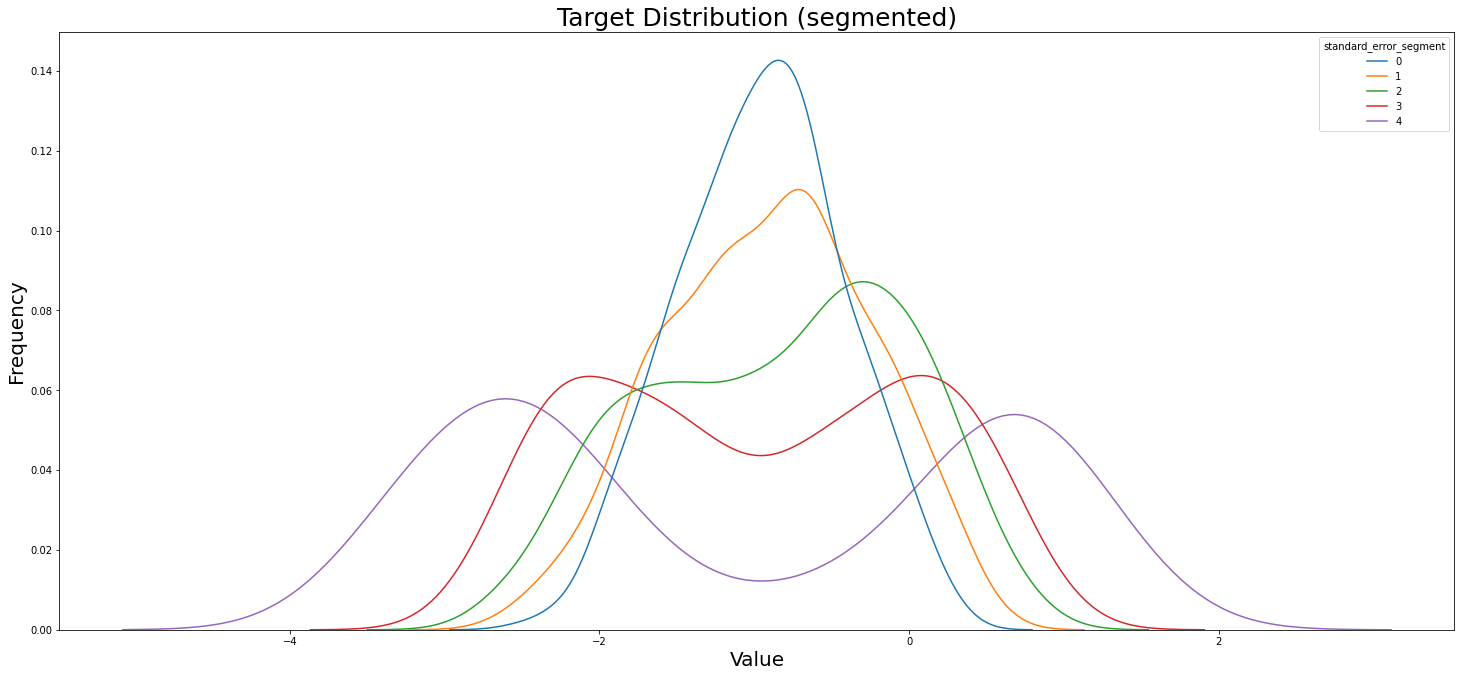

In [9]:
plt.figure(figsize = (25, 11))
sns.kdeplot(pd_train["target"], hue=pd_train["standard_error_segment"])
plt.title("Target Distribution (segmented)", size=25)
plt.xlabel("Value", size=20)
plt.ylabel("Frequency", size=20)

<AxesSubplot:xlabel='target', ylabel='standard_error_segment'>

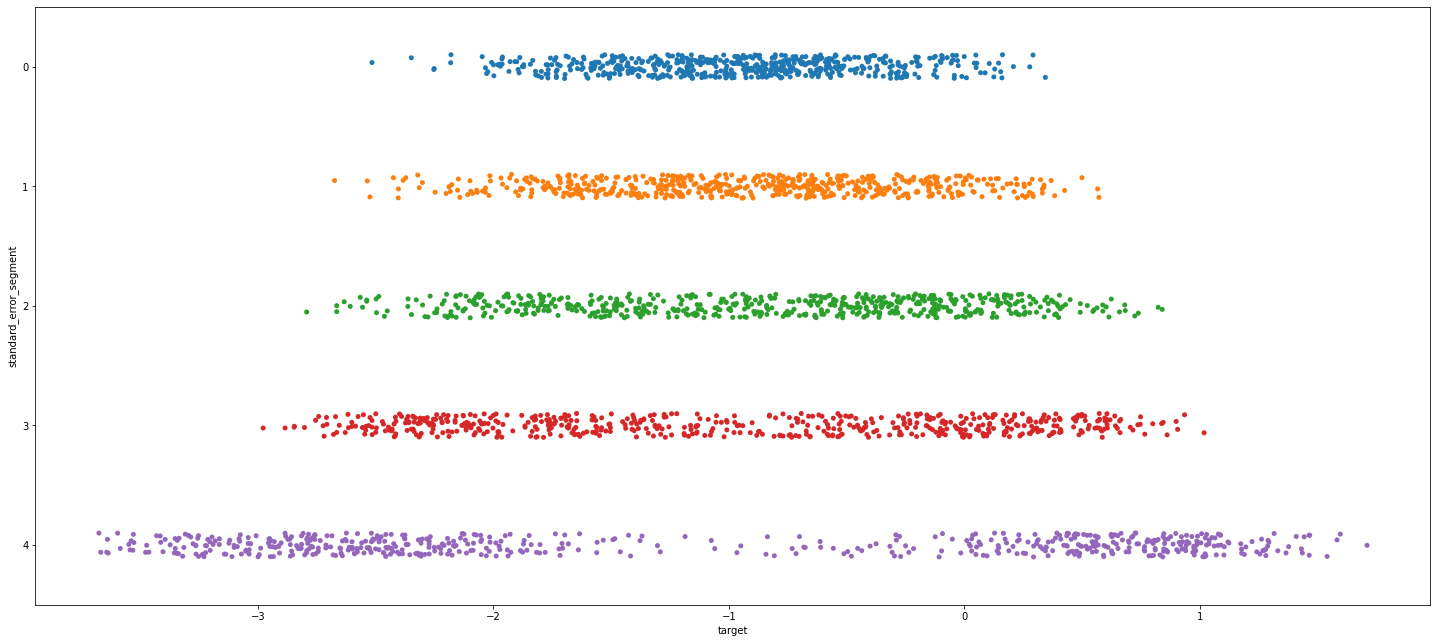

In [10]:
plt.figure(figsize = (25, 11))
sns.stripplot(x=pd_train.target, y=pd_train.standard_error_segment, dodge=True)

In [11]:
for group in range(bins):
    print('-'*150)
    print('Details of group: ', group)
    print('Unique values length: ', len(np.unique(pd_train[pd_train.standard_error_segment == str(group)]["target"])))
    print('Group values length: ', len(pd_train[pd_train.standard_error_segment == str(group)]["target"]))

print('-'*150)
print('Overall Unique values: ', len(np.unique(pd_train.target)))
print('Overall Unique values: ', len(pd_train.target))

------------------------------------------------------------------------------------------------------------------------------------------------------
Details of group:  0
Unique values length:  566
Group values length:  566
------------------------------------------------------------------------------------------------------------------------------------------------------
Details of group:  1
Unique values length:  566
Group values length:  566
------------------------------------------------------------------------------------------------------------------------------------------------------
Details of group:  2
Unique values length:  566
Group values length:  566
------------------------------------------------------------------------------------------------------------------------------------------------------
Details of group:  3
Unique values length:  566
Group values length:  566
----------------------------------------------------------------------------------------------------

In [12]:
lb = LabelBinarizer()
lb = lb.fit(pd_train.standard_error_segment.values)
pd_train['labels'] = lb.transform(pd_train.standard_error_segment.values).tolist()
pd_train.columns

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error',
       'standard_error_segment', 'labels'],
      dtype='object')

In [13]:
pd_train.drop(columns=['id', 'url_legal', 'license', 'target', 'standard_error', 'standard_error_segment'], axis=1, inplace=True)

In [14]:
train_testeval = (datasets.Dataset.from_pandas(df=pd_train)).train_test_split(train_size=.8, test_size=.2, seed=seed)
train_testeval

DatasetDict({
    train: Dataset({
        features: ['excerpt', 'labels'],
        num_rows: 2267
    })
    test: Dataset({
        features: ['excerpt', 'labels'],
        num_rows: 567
    })
})

In [15]:
test_eval = train_testeval['test'].train_test_split(train_size=.75, test_size=.25, seed=seed)
test_eval

DatasetDict({
    train: Dataset({
        features: ['excerpt', 'labels'],
        num_rows: 425
    })
    test: Dataset({
        features: ['excerpt', 'labels'],
        num_rows: 142
    })
})

In [16]:
ds = datasets.DatasetDict({
    'train': train_testeval['train'],
    'test': test_eval['test'],
    'valid': test_eval['train']})

In [17]:
# peek at one example
ds["train"][0]

{'excerpt': 'The instrument consists of two permanent horseshoe magnets, fixed parallel with each other and an inch apart. A very thin spool or bobbin of insulated wire is suspended, like the pendulum of a clock, between these permanent magnets, in such a manner that the bobbin hangs just in front of the four poles. A counterpoise is fixed at the top of the pendulum bar, which permits the adjusting of the antagonistic forces represented by the action of the swinging bobbin, and two springs, which are insulated from the mass, and which form one electrode of the local or annunciator circuit, while the pendulum bar forms the other. It will be easily understood that as the bobbin hangs freely in the center of a very strong magnetic field formed by the four poles of the two permanent magnets, the slightest current sent through the bobbin will cause the bobbin to be attracted from one direction, while it will be repelled from the other, according to the polarity of the current transmitted.',

## Tokenize and encode 

In [18]:
model_ckpt = "roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, problem_type="multi_label_classification")

In [19]:
# max_length cannot be set in our transformers-multilabel-text-classification-without-problem-type-and-datasets.ipynb
def tokenize_and_encode(examples):
    return tokenizer.batch_encode_plus(examples["excerpt"], truncation=True, padding=True, max_length=120)

In [20]:
cols = ds["train"].column_names
cols.remove("labels")
ds_enc = ds.map(tokenize_and_encode, batched=True, remove_columns=cols, num_proc=2)
ds_enc

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 2267
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 142
    })
    valid: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 425
    })
})

In [21]:
# cast label IDs to floats
ds_enc.set_format("torch")
ds_enc = (ds_enc
          .map(lambda x : {"float_labels": x["labels"].to(torch.float)}, remove_columns=["labels"])
          .rename_column("float_labels", "labels"))

## Load model

In [22]:
num_labels=5
# Setting output_hidden_states to True will cause the epoch evaluation to fail, because the output will be the last layer embeddings and not the loss
# Enable this feature only during predictions
# output_hidden_states=True
model = AutoModelForSequenceClassification.from_pretrained('../data/mlm/model', num_labels=num_labels, problem_type="multi_label_classification").to('cuda')

Some weights of the model checkpoint at ../data/mlm/model were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../data/mlm/model and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classif

## Load trainer

In [23]:
ds_enc["train"][0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor([0., 0., 1., 0., 0.]),
 'input_ids': tensor([    0,   133, 10320, 10726,     9,    80,  4398, 31690,  4891,  3540,
         39362,     6,  4460, 12980,    19,   349,    97,     8,    41, 10468,
          4102,     4,    83,   182,  7174,  2292,  8110,    50, 22401,  9413,
             9, 36027,  8869,    16,  3456,     6,   101,     5, 35394, 28712,
             9,    10,  6700,     6,   227,   209,  4398, 39362,     6,    11,
           215,    10,  4737,    14,     5, 22401,  9413, 23835,    95,    11,
           760,     9,     5,   237, 20588,    

In [24]:
batch_size = 16
# configure logging so we see training loss
logging_steps = len(ds_enc['train']) // batch_size

training_args = TrainingArguments(
    output_dir='../data/seqclas/results0',                  # output directory
    evaluation_strategy = "epoch",                          # evaluate model after every epoch
    num_train_epochs=15,                                    # total number of training epochs
    learning_rate=1e-5,                                     # starting learning rate
    per_device_train_batch_size=batch_size,                 # batch size per device during training
    per_device_eval_batch_size=batch_size,                  # batch size for evaluation
    warmup_steps=500,                                       # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                                      # strength of weight decay
    logging_dir='../data/seqclas/logs0',                    # directory for storing logs
    logging_steps=logging_steps,
    report_to="none",
    seed=seed,
    fp16=True,
    eval_accumulation_steps=5,
)

In [25]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    converted_labels = [int(i) for i in lb.inverse_transform(labels)]
    return {'f1_score': f1_score(y_true=converted_labels, y_pred=predictions, average='weighted'), 
            'accuracy': accuracy_score(y_true=converted_labels, y_pred=predictions)}

In [26]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = ds_enc['train'],
    eval_dataset = ds_enc['valid'],
    compute_metrics = compute_metrics,
    tokenizer = tokenizer
)

In [27]:
trainer.evaluate()

{'eval_loss': 0.673801839351654,
 'eval_f1_score': 0.08011787373909102,
 'eval_accuracy': 0.2211764705882353,
 'eval_runtime': 3.6425,
 'eval_samples_per_second': 116.678,
 'eval_steps_per_second': 7.412}

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Score,Accuracy
1,0.590300,0.505646,0.157219,0.183529
2,0.508300,0.504495,0.158012,0.214118
3,0.501300,0.511528,0.098354,0.195294
4,0.494600,0.502947,0.180615,0.240000
5,0.470700,0.520205,0.180913,0.221176
6,0.409900,0.545445,0.212329,0.249412
7,0.327300,0.579204,0.221127,0.218824
8,0.231900,0.662185,0.231820,0.249412
9,0.145100,0.737523,0.211046,0.216471
10,0.089200,0.838663,0.211865,0.216471


TrainOutput(global_step=2130, training_loss=0.2580106668349163, metrics={'train_runtime': 589.5122, 'train_samples_per_second': 57.683, 'train_steps_per_second': 3.613, 'total_flos': 8700611306648400.0, 'train_loss': 0.2580106668349163, 'epoch': 15.0})

In [29]:
trainer.evaluate()

{'eval_loss': 1.078865647315979,
 'eval_f1_score': 0.2255481339749377,
 'eval_accuracy': 0.23529411764705882,
 'eval_runtime': 3.683,
 'eval_samples_per_second': 115.396,
 'eval_steps_per_second': 7.331,
 'epoch': 15.0}

In [32]:
trainer.predict(test_dataset=ds_enc['test'])[2]

{'test_loss': 0.9404212832450867,
 'test_f1_score': 0.27725119517085545,
 'test_accuracy': 0.2746478873239437,
 'test_runtime': 1.2216,
 'test_samples_per_second': 116.243,
 'test_steps_per_second': 7.367}

In [33]:
model.save_pretrained('../data/seqclas/model0')

## Let us use the CLS token as embeddings and run pycaret ouver them and see if we can improve our metrics, Look for 'transformers_embeddings_pycaret_classification.ipynb'